## Imports

In [10]:
# IMPORTS
import numpy as np
import pandas as pd
import keras
from keras import layers
import random
from keras.utils import to_categorical


## Classes

In [11]:
# CLASSES

class Device:
    def __init__(self, id, ram, storage, cpu, bandwidth, battery, charging):
        self.id = id
        self.ram = ram
        self.storage = storage
        self.cpu = cpu
        self.bandwidth = bandwidth
        self.battery = battery
        self.charging = charging
        self.model: keras.Sequential = Server.create_model()
        self.last_round_participated = 0
        self.data = None  # Placeholder for dataset partition
        self.test_data = None
        self.number_of_times_fitted = 0
        self.hardware_value_sum = 0.0
        
    def lose_battery(self):
        if self.hardware_value_sum > 0.3:
            self.hardware_value_sum -= 0.3
        else:
            self.hardware_value_sum = 0
            print("device turned off!")
        
        # if float(self.battery) > 0.3:
        #     self.battery -= 0.3
        # else:
        #     self.battery = 0
        #     print("device turned off!")

class Server:
    def __init__(self, devices_list: list[Device]):
        self.model: keras.Sequential = Server.create_model()
        self.current_learning_iteration = 0
        self.LAST_WEIGHTS_SENT_FOR_ALL_DEVICES = []
        self.x_test_global = []
        self.y_test_global = []
        self.devices = devices_list
               
        # The variables below are used to keep track of the remaining rounds and generations and to store the variances
        # They do not logically belong to the Server class
        self.remaining_generation = 0
        self.remaining_round = 0
        self.variances = []  # List to store variances as [round, gen, solution, variance]
        self.pareto_fronts = [] # List to store pareto fronts as [round, gen, solution]

    def evaluate(self, x_test=None, y_test=None, verbose = 0):
        if x_test is None and y_test is None:
            test_loss, test_acc = self.model.evaluate(self.x_test_global, self.y_test_global, verbose)
            return test_loss, test_acc
        test_loss, test_acc = self.model.evaluate(x_test, y_test, verbose=verbose)
        return test_loss, test_acc

    def get_weights(self):
        return self.model.get_weights()

    def set_aggregated_weight(self):
        self.model.set_weight(Server.aggregate_weights())

    def give_global_model_weights_to_bitstring_devices(self, bitstring):
        for device in self.devices:
            if int(bitstring[int(device.id)]) == 1:
                device.model.set_weights(self.model.get_weights())

    def create_model() -> keras.Sequential:
        model = keras.Sequential([
            layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dense(10, activation='softmax')
        ])
        model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01),
                        # new
                        loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    def aggregate_weights(self, bitstring):
        """Computes the weighted average of model weights from all devices and updates the global model."""
        def sum_all_nested_lists(list_of_lists):
            def recursive_sum(lists):
                if isinstance(lists[0], list):
                    return [recursive_sum([lst[i] for lst in lists]) for i in range(len(lists[0]))]
                else:
                    return sum(lists)

            return recursive_sum(list_of_lists)

        def multiply_nested_list(lst, factor):
            result = []
            for item in lst:
                if isinstance(item, list):
                    # Recursively handle sublists
                    result.append(multiply_nested_list(item, factor))
                else:
                    # Multiply number
                    result.append(item * factor)
            return result

        selected_devices = []
        for device in self.devices:
            if int(bitstring[int(device.id)]) == 1:
                selected_devices.append(device)

        num_devices = len(selected_devices)
        if num_devices == 0:
            print("No devices available for aggregation.")
            return

        device_participation_ratio = []
        data_lengths = []

        for device in selected_devices:
            # print("*******************")
            # print(device.id)
            device_participation_ratio.append(device.last_round_participated / self.current_learning_iteration)
            # print("this device's participation ratio:")
            # print(device.last_round_participated / self.current_learning_iteration)
            data_lengths.append(len(device.data[0]))
            # print("this device's data to all ratio:")
            # print(len(device.data[0])/60000.0)

        sum_data = 0
        for data_len in data_lengths:
            sum_data += data_len

        data_fractions = []
        for device in selected_devices:
            data_fractions.append(len(device.data[0])/float(sum_data))



        combined_weights = [fraction * ratio for fraction, ratio in zip(data_fractions, device_participation_ratio)]
        total_weight = sum(combined_weights)
        normalized_weights = [w / total_weight for w in combined_weights]
        # print(normalized_weights)


        aggregated_weights_devices = []
        for d in range(len(selected_devices)):
            # aggregated_weights_devices.append(multiply_nested_list(selected_devices[d].model.get_weights(), data_fractions[d]*device_participation_ratio[d]))
            aggregated_weights_devices.append(multiply_nested_list(self.LAST_WEIGHTS_SENT_FOR_ALL_DEVICES[int(selected_devices[d].id)], normalized_weights[d]))

        aggregated_weights = sum_all_nested_lists(aggregated_weights_devices)
        # TODO: Weighted multiplication for each node in each layer of the neural network of the received devices and then summing
        #       the related parts together so that we get a full weighted average of all these devices' models

        # print("Aggregated weights:")
        # for layer_idx, layer_weights in enumerate(aggregated_weights):
            # print(f"Layer {layer_idx}: {layer_weights.shape}")
            
        
        return aggregated_weights




## Functions

In [12]:
# Functions

def fit_bitstring_devices(bitstring, server: Server, epochs=7):
    '''
    server: for using its "current_learning_iteration" variable
    '''

    server.current_learning_iteration += 1
    for device in server.devices:
        if int(bitstring[int(device.id)]) == 1:
            # TODO:
            # makes it so that the selection might choose a device that's been turned off
            # if the device is off, don't fit, use old weights saved on the server.
            # if the device is on, fit, update the weights saved on the server.
            # TODO:
            # COMMENTED FOR NOW, SINCE IT ALREADY AFFECTS NSGA2 EVALUATION
            
            # if device.hardware_value_sum :
            #     continue
            
            device.lose_battery()
            
            device.model.fit(device.data[0], device.data[1], epochs=epochs, verbose=0)
            # print(device.id)
            device.last_round_participated = server.current_learning_iteration
            server.LAST_WEIGHTS_SENT_FOR_ALL_DEVICES[int(device.id)] = device.model.get_weights()
            device.number_of_times_fitted += 1




def niid_labeldir_split(x_data, y_data, num_clients, beta, seed=None):
    num_classes = 10
    y_indices = np.array([np.argmax(label) for label in y_data])  # From one-hot to class index
    
    rng = np.random.default_rng(seed)  # Local random generator

    # Prepare client partitions
    client_indices = [[] for _ in range(num_clients)]

    for k in range(num_classes):
        idx_k = np.where(y_indices == k)[0]
        rng.shuffle(idx_k)

        # Dirichlet distribution for class k
        proportions = rng.dirichlet(np.repeat(beta, num_clients))

        # Scale proportions to match the number of available samples
        proportions = np.array([int(p * len(idx_k)) for p in proportions])
        # Fix total due to rounding
        while sum(proportions) < len(idx_k):
            proportions[np.argmin(proportions)] += 1
        while sum(proportions) > len(idx_k):
            proportions[np.argmax(proportions)] -= 1

        start = 0
        for i in range(num_clients):
            size = proportions[i]
            client_indices[i].extend(idx_k[start:start + size])
            start += size

    return client_indices



def random_hardware_value_for_devices(devices: list[Device]):
    random_values = [3.91, 0.62, 1.79, 4.96, 5.87, 2.14, 1.41, 5.18, 2.80, 3.00, 0.20, 1.02, 5.73, 0.69, 4.27,
                     5.37, 1.62, 0.93, 3.61, 2.90, 4.53, 2.13, 3.01, 0.07, 1.34, 3.90, 0.28, 1.89, 5.95, 2.76]
    
    for idx in range(len(devices)):
        devices[idx].hardware_value_sum = random_values[idx]
    
    print("Successfully gave each device a random value between 0 and 6 for its hardware objective!")


## Load Data

### Load Devices

In [13]:
# Load dataset from CSV
csv_file = 'devices.csv'
df = pd.read_csv(csv_file)
df.columns = df.columns.str.strip().str.lower()

# Convert CSV rows into device objects
devices = []

for _, row in df.iterrows():
    device = Device(
        row['id'], row['ram'], row['storage'], row['cpu'], row['bandwidth'], row['battery'],
        row.get('charging', 0)
    )
    devices.append(device)


# LIMIT TO 30 DEVICES
devices = devices[:30]

random_hardware_value_for_devices(devices)

d:\github project\FL\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully gave each device a random value between 0 and 6 for its hardware objective!


### Object Initializations

In [14]:
# Global Model
server = Server(devices_list=devices)
server.LAST_WEIGHTS_SENT_FOR_ALL_DEVICES = [None for _ in range(len(devices))]

### Split Data Among Devices

In [15]:
SEED = 1
# np.random.seed(SEED)
# np.random.random_integers(1, 10)

In [16]:


# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Convert labels to categorical (one-hot encoded)
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Normalize data and reshape for CNN
x_train = x_train.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1)  # Add channel dimension

x_test = x_test.astype("float32") / 255.0
x_test = np.expand_dims(x_test, -1)  # Add channel dimension

# Shuffle data
# indices = np.arange(len(x_train))
# np.random.shuffle(indices)
# x_train, y_train = x_train[indices], y_train[indices]




# Lower the amount of data for devices
x_train = x_train[:int(len(x_train)/6)] # was 8
y_train = y_train[:int(len(y_train)/6)]




# Correct test split
split_index = int(0.8 * len(x_test))
x_test_devices, y_test_devices = x_test[:split_index], y_test[:split_index]
server.x_test_global, server.y_test_global = x_test[split_index:], y_test[split_index:]

# Training data (for devices)
x_train_devices, y_train_devices = x_train, y_train

# Split training data among devices
beta = 0.5  # lower = more skewed
num_devices = len(devices)
split_indices = niid_labeldir_split(x_train_devices, y_train_devices, num_devices, beta, seed=SEED)

for i, device in enumerate(devices):
    idxs = split_indices[i]

    from sklearn.model_selection import train_test_split

    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(x_train_devices[idxs], y_train_devices[idxs], test_size=0.3, random_state=42)

    device.data = [X_train, y_train]
    device.test_data = [X_test, y_test]

    print("X_train shape:", X_train.shape)
    print("X_test shape:", X_test.shape)
    print("y_train shape:", y_train.shape)
    print("y_test shape:", y_test.shape)


#TODO:
# how does each objective get better through populations? maybe put em on a scale

X_train shape: (118, 28, 28, 1)
X_test shape: (51, 28, 28, 1)
y_train shape: (118, 10)
y_test shape: (51, 10)
X_train shape: (104, 28, 28, 1)
X_test shape: (45, 28, 28, 1)
y_train shape: (104, 10)
y_test shape: (45, 10)
X_train shape: (151, 28, 28, 1)
X_test shape: (66, 28, 28, 1)
y_train shape: (151, 10)
y_test shape: (66, 10)
X_train shape: (220, 28, 28, 1)
X_test shape: (95, 28, 28, 1)
y_train shape: (220, 10)
y_test shape: (95, 10)
X_train shape: (291, 28, 28, 1)
X_test shape: (125, 28, 28, 1)
y_train shape: (291, 10)
y_test shape: (125, 10)
X_train shape: (182, 28, 28, 1)
X_test shape: (78, 28, 28, 1)
y_train shape: (182, 10)
y_test shape: (78, 10)
X_train shape: (186, 28, 28, 1)
X_test shape: (81, 28, 28, 1)
y_train shape: (186, 10)
y_test shape: (81, 10)
X_train shape: (157, 28, 28, 1)
X_test shape: (68, 28, 28, 1)
y_train shape: (157, 10)
y_test shape: (68, 10)
X_train shape: (357, 28, 28, 1)
X_test shape: (154, 28, 28, 1)
y_train shape: (357, 10)
y_test shape: (154, 10)
X_trai

In [17]:
# test
a, b =devices[23].test_data
print(len(a))

110


### Load Other Data

## First Iteration

In [18]:
# First Iteration
bitstring = [1 for _ in range(len(devices))]
print(bitstring)



# Save weights to a file
# The file name should end in .weights.h5
# The weights can be loaded into a model using model.load_weights('model.weights.h5')
server.model.save_weights('my_model.weights.h5')

# global model sends its weights to all devices
server.give_global_model_weights_to_bitstring_devices(bitstring)



test_loss, test_acc = server.evaluate(verbose=0)
print(f"Global Model Accuracy: {test_acc:.2f}")
print("------------------------------------------------------------")
fit_bitstring_devices(bitstring, server)
server.model.set_weights(server.aggregate_weights(bitstring))
print("------------------------------------------------------------")
test_loss, test_acc = server.evaluate(verbose=0)
print(f"Global Model Accuracy: {test_acc:.2f}")

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0643 - loss: 2.3534
Global Model Accuracy: 0.06
------------------------------------------------------------
device turned off!
device turned off!
device turned off!
------------------------------------------------------------
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6350 - loss: 1.8255
Global Model Accuracy: 0.64


In [19]:
!pip install pymoo

## NSGA2 Loop

In [20]:
# Parameters
NUM_ROUNDS = 4 # should be 4

server.remaining_round = NUM_ROUNDS

In [21]:
# DEBUG:
print(server.x_test_global.shape)
print(server.y_test_global.shape)

print(x_train.shape)
print(y_train.shape)

(2000, 28, 28, 1)
(2000, 10)
(10000, 28, 28, 1)
(80, 10)


In [22]:
all_runs_fronts = []  # Stores results across runs
all_runs_solutions = []

VARIANCES = []

needed_values_for_comparison = ""

for i in range(NUM_ROUNDS):
    server.remaining_round = NUM_ROUNDS - i

    # Generate bitstring
    bitstring = [1 for i in range(30)]
    ###############################
    print(bitstring)
    print(bitstring[0])
    print(type(bitstring[0]))
    # global model sends its weights to all devices
    server.give_global_model_weights_to_bitstring_devices(bitstring)

    test_loss, test_acc = server.evaluate(verbose=0)
    print(f"Global Model Accuracy: {test_acc:.2f}")
    print("------------------------------------------------------------")
    fit_bitstring_devices(bitstring, server)
    server.model.set_weights(server.aggregate_weights(bitstring))
    print("------------------------------------------------------------")
    test_loss, test_acc = server.evaluate(verbose=0)
    print(f"Global Model Accuracy: {test_acc:.2f}")
    
    # ---
    
    accuracies = []

    for device in server.devices:
        x_test = device.test_data[0]
        y_test = device.test_data[1]
        
        loss, accuracy = server.evaluate(x_test, y_test)
        
        accuracies.append(round(accuracy, 2))
        print(f"Device {device.id} Accuracy: {round(accuracy, 2)}")

    VARIANCE = np.var(accuracies)
    VARIANCE_SCORE = 1.0/VARIANCE
    MEAN = np.mean(accuracies)
    STANDARD_DEVIATION = np.std(accuracies)
    FAIRNESS = 1.0/STANDARD_DEVIATION
    
    needed_values_for_comparison += f"Round: {i+1}\nServer Test Accuracy: {test_acc}\nVariance: {VARIANCE}\nVariance Score: {VARIANCE_SCORE}\nMean: {MEAN}\nStandard Deviation: {STANDARD_DEVIATION}\nFairness: {FAIRNESS}\n---\n"

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
1
<class 'int'>
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6350 - loss: 1.8255
Global Model Accuracy: 0.64
------------------------------------------------------------
device turned off!
device turned off!
device turned off!
------------------------------------------------------------
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8567 - loss: 1.0378
Global Model Accuracy: 0.84
Device 0.0 Accuracy: 0.57
Device 1.0 Accuracy: 0.67
Device 2.0 Accuracy: 0.85
Device 3.0 Accuracy: 0.78
Device 4.0 Accuracy: 0.83
Device 5.0 Accuracy: 0.82
Device 6.0 Accuracy: 0.91
Device 7.0 Accuracy: 0.91
Device 8.0 Accuracy: 0.86
Device 9.0 Accuracy: 0.73
Device 10.0 Accuracy: 0.79
Device 11.0 Accuracy: 0.77
Device 12.0 Accuracy: 0.73
Device 13.0 Accuracy: 0.8
Device 14.0 Accuracy: 0.78
Device 15.0 Accuracy: 0.76
Device 16.0 Accuracy: 0.89
Device 17.0 Accuracy: 0.87
Device 18.0 Accuracy: 0.71
Device 19.

In [27]:
# x = objective 1
# y = objective 2
# z = objective 3

def get_min_objective_value(run_index: int, generation_index: int, objective_index: int, verbose: int=0):
    temp_list = []
    for solution_objective_values in all_runs_fronts[run_index][generation_index]:
        temp_list.append(solution_objective_values[objective_index])
    if verbose == 1:
        print(f"For the run index {run_index} and generation index {generation_index}:")
        print(f"MIN of objective index {objective_index}: {min(temp_list)}")
    return min(temp_list)

def get_max_objective_value(run_index: int, generation_index: int, objective_index: int, verbose: int=0):
    temp_list = []
    for solution_objective_values in all_runs_fronts[run_index][generation_index]:
        temp_list.append(solution_objective_values[objective_index])
    if verbose == 1:
        print(f"For the run index {run_index} and generation index {generation_index}:")
        print(f"MAX of objective index {objective_index}: {max(temp_list)}")
    return max(temp_list)

In [30]:
print(server.evaluate())

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9228 - loss: 0.3492
(0.3977741003036499, 0.9100000262260437)


In [42]:
!pip install nbformat>=4.2.0
!pip show nbformat


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Name: nbformat
Version: 5.10.4
Summary: The Jupyter Notebook format
Home-page: https://jupyter.org
Author: 
Author-email: Jupyter Development Team <jupyter@googlegroups.com>
License: BSD 3-Clause License

- Copyright (c) 2001-2015, IPython Development Team
- Copyright (c) 2015-, Jupyter Development Team

All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its
   contributors may be used to endorse or promote products derived from
   this software without specific prior writte

In [44]:
import plotly.graph_objects as go
import plotly.io as pio
import pandas as pd

pio.renderers.default = 'browser' # 'notebook'

# Example data (replace with your own)
data = VARIANCES
for item in data:
    print(item)

# Convert to DataFrame for easy grouping
df = pd.DataFrame(data, columns=["round_idx", "gen_idx", "bitstring", "variance"])

# For each round & generation, find the row with minimum variance
df_min = df.loc[df.groupby(["round_idx", "gen_idx"])["variance"].idxmin()]

# Create interactive plot
fig = go.Figure()

for round_val, group in df_min.groupby("round_idx"):
    print(group)
    fig.add_trace(
        go.Scatter(
            x=group["gen_idx"],
            y=group["variance"],
            mode="lines+markers",
            name=f"Round {round_val}",
            text=[f"Bitstring: {b}" for b in group["bitstring"]],
            hovertemplate="Gen: %{x}<br>Variance: %{y}<br>%{text}"
        )
    )

fig.update_layout(
    title="Minimum Variance per Generation for Each Round",
    xaxis_title="Generation Index",
    yaxis_title="Variance",
    hovermode="closest"
)

fig.show()


In [45]:
accuracies = []

for device in server.devices:
    x_test = device.test_data[0]
    y_test = device.test_data[1]
    
    loss, accuracy = server.evaluate(x_test, y_test)
    
    accuracies.append(round(accuracy, 2))
    print(f"Device {device.id} Accuracy: {round(accuracy, 2)}")

VARIANCE = np.var(accuracies)
VARIANCE_SCORE = 1.0/VARIANCE
MEAN = np.mean(accuracies)
STANDARD_DEVIATION = np.std(accuracies)

Device 0.0 Accuracy: 0.86
Device 1.0 Accuracy: 0.76
Device 2.0 Accuracy: 0.94
Device 3.0 Accuracy: 0.82
Device 4.0 Accuracy: 0.88
Device 5.0 Accuracy: 0.86
Device 6.0 Accuracy: 0.94
Device 7.0 Accuracy: 0.94
Device 8.0 Accuracy: 0.9
Device 9.0 Accuracy: 0.81
Device 10.0 Accuracy: 0.86
Device 11.0 Accuracy: 0.89
Device 12.0 Accuracy: 0.77
Device 13.0 Accuracy: 0.93
Device 14.0 Accuracy: 0.85
Device 15.0 Accuracy: 0.86
Device 16.0 Accuracy: 0.93
Device 17.0 Accuracy: 0.93
Device 18.0 Accuracy: 0.89
Device 19.0 Accuracy: 0.88
Device 20.0 Accuracy: 0.83
Device 21.0 Accuracy: 0.84
Device 22.0 Accuracy: 0.89
Device 23.0 Accuracy: 0.85
Device 24.0 Accuracy: 0.89
Device 25.0 Accuracy: 0.84
Device 26.0 Accuracy: 0.85
Device 27.0 Accuracy: 0.95
Device 28.0 Accuracy: 0.8
Device 29.0 Accuracy: 0.89


In [46]:
print(f"MEAN: {MEAN}")
print(f"VARIANCE: {VARIANCE}")
print(f"STANDARD_DEVIATION: {STANDARD_DEVIATION}")
print(f"Fairness: {1.0/STANDARD_DEVIATION}")

MEAN: 0.871
VARIANCE: 0.0024356666666666663
STANDARD_DEVIATION: 0.04935247376440888
Fairness: 20.262408826225077


In [47]:
print(needed_values_for_comparison)

Round: 1
Server Test Accuracy: 0.843500018119812
Variance: 0.006429333333333335
Variance Score: 155.5371215263376
Mean: 0.792
Standard Deviation: 0.08018312374392342
Fairness: 12.47145226211998
---
Round: 2
Server Test Accuracy: 0.8774999976158142
Variance: 0.004259555555555556
Variance Score: 234.76627712854753
Mean: 0.8293333333333331
Standard Deviation: 0.06526527066944222
Fairness: 15.32208462085194
---
Round: 3
Server Test Accuracy: 0.9054999947547913
Variance: 0.002579555555555556
Variance Score: 387.6636802205375
Mean: 0.8606666666666666
Standard Deviation: 0.05078932521264243
Fairness: 19.689176727850697
---
Round: 4
Server Test Accuracy: 0.9100000262260437
Variance: 0.0024356666666666663
Variance Score: 410.56521144108393
Mean: 0.871
Standard Deviation: 0.04935247376440888
Fairness: 20.262408826225077
---



In [48]:
accuracy_plot_x = []
accuracy_plot_y = []

for item in needed_values_for_comparison.split("---")[:-1]:
    for subitem in item.split("\n"):
        if "Server Test Accuracy" in subitem:
            print(float(subitem[subitem.find(": ")+2:]))
            accuracy_plot_y.append(float(subitem[subitem.find(": ")+2:]))
        
    accuracy_plot_x.append(needed_values_for_comparison.split("---").index(item)+1)
        
print(accuracy_plot_x)
print(accuracy_plot_y)

0.843500018119812
0.8774999976158142
0.9054999947547913
0.9100000262260437
[1, 2, 3, 4]
[0.843500018119812, 0.8774999976158142, 0.9054999947547913, 0.9100000262260437]


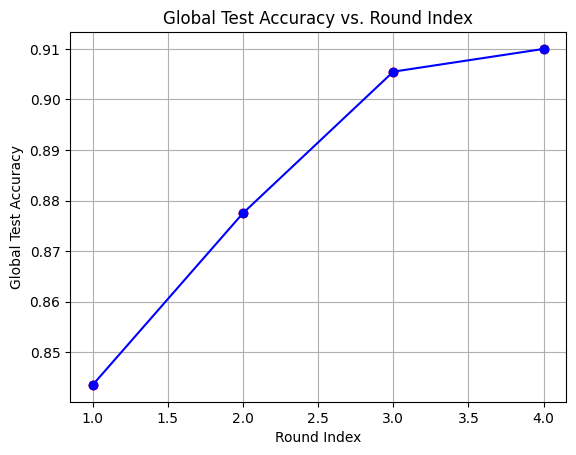

In [49]:
import matplotlib.pyplot as plt

# Example points (replace with your own x and y values)
x = accuracy_plot_x
y = accuracy_plot_y

# Scatter plot of points
plt.scatter(x, y, color='red', zorder=2)

# Plot line with markers
plt.plot(x, y, marker='o', linestyle='-', color='blue')

# Highlight the points explicitly if you like
plt.scatter(x, y, color='red')

plt.xlabel("Round Index")
plt.ylabel("Global Test Accuracy")
plt.title("Global Test Accuracy vs. Round Index")
plt.grid(True)
plt.show()
